In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv1D, Flatten, LSTM
import warnings
warnings.filterwarnings('ignore')
from collections import Counter



In [9]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [10]:
file_path = '/content/drive/MyDrive/CPT_II_ConnersContinuousPerformanceTest.csv'
df = pd.read_csv(file_path, delimiter=';')
df.head()


,ID,Assessment Status,Assessment Duration,Type,LastTrial,Trial1,Response1,Trial2,Response2,Trial3,...,Raw Score HitRTIsi,Percent HitRTIsi,General TScore HitSEIsi,Adhd TScore HitSEIsi,Neuro TScore HitSEIsi,Raw Score HitSEIsi,Percent HitSEIsi,Adhd Confidence Index,Neuro Confidence Index,Old Overall Index
0,2,3,839999,6,360,11,-1,13,469,7,...,0.049592,0,48.021103,47.772537,43.224297,-0.021096,0,61.145496,58.749630,10.070000
1,3,3,839999,6,360,12,-1,0,371,2,...,0.064090,0,42.234097,38.263283,41.574574,-0.077351,0,86.871597,61.088688,4.440000
2,4,3,839999,6,360,14,-1,10,-1,3,...,0.077233,0,45.680782,42.289310,43.868061,-0.046142,0,99.900002,86.131813,18.340000
3,5,3,839999,6,360,12,459,7,289,12,...,0.085540,0,85.698700,70.469986,80.228539,0.410634,0,99.900002,99.900002,8.950001
4,7,3,839998,6,360,11,841,7,-1,5,...,0.024632,0,42.058998,43.349667,39.992119,-0.071200,0,32.291084,24.225414,0.000000


In [11]:
df.isna().sum()

,0
ID,0
Assessment Status,0
Assessment Duration,0
Type,0
LastTrial,0
...,...
Raw Score HitSEIsi,0
Percent HitSEIsi,0
Adhd Confidence Index,0
Neuro Confidence Index,0


In [12]:
df.isna().sum().sum()

np.int64(0)

In [13]:
# Define target variable (ADHD Confidence Index as binary classification)
df['ADHD_Diagnosis'] = (df['Adhd Confidence Index'] > 50).astype(int)  # 1 = ADHD, 0 = No ADHD



In [14]:
# Reuse your full dataset from previous block
file_path = '/content/drive/MyDrive/CPT_II_ConnersContinuousPerformanceTest.csv'
df = pd.read_csv(file_path, delimiter=';')
df.columns = df.columns.str.strip()
df['ADHD_Diagnosis'] = (df['Adhd Confidence Index'] > 50).astype(int)

# Drop ID and irrelevant columns
X_full = df.drop(columns=['ID', 'Adhd Confidence Index', 'ADHD_Diagnosis'], errors='ignore')
y = df['ADHD_Diagnosis']

# Fill missing values
X_full.replace(-1, np.nan, inplace=True)
X_full.fillna(X_full.median(numeric_only=True), inplace=True)

# Encode categorical columns
for col in X_full.select_dtypes(include='object').columns:
    X_full[col] = LabelEncoder().fit_transform(X_full[col])

# Feature selection using Random Forest
rf_selector = RandomForestClassifier(n_estimators=100, random_state=42)
rf_selector.fit(X_full, y)
feature_importance = pd.DataFrame({
    'Feature': X_full.columns,
    'Importance': rf_selector.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Select top 15 features
top_15_features = feature_importance.head(15)['Feature'].tolist()
X_top15 = X_full[top_15_features]

# Scale both full and top 15 datasets
scaler = StandardScaler()
X_all_scaled = scaler.fit_transform(X_full)
X_top15_scaled = scaler.fit_transform(X_top15)

# Train-test split
X_all_train, X_all_test, y_train, y_test = train_test_split(X_all_scaled, y, test_size=0.2, random_state=42)
X_top_train, X_top_test = train_test_split(X_top15_scaled, test_size=0.2, random_state=42)

# Define models again
models = {
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    "LightGBM": LGBMClassifier(),
    "GaussianNB": GaussianNB()
}

# Function to train and evaluate
def evaluate_models(X_train, X_test, y_train, y_test, label):
    print(f"\n=== Results using {label} ===")
    result_data = []
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_prob = model.predict_proba(X_test)[:, 1]

        result_data.append({
            "Model": name,
            "Feature Set": label,
            "Accuracy": accuracy_score(y_test, y_pred),
            "Precision": precision_score(y_test, y_pred),
            "Recall": recall_score(y_test, y_pred),
            "F1-Score": f1_score(y_test, y_pred),
            "ROC-AUC": roc_auc_score(y_test, y_prob)
        })

        print(f"\n{name} Classification Report ({label}):\n")
        print(classification_report(y_test, y_pred))

    return result_data

# Evaluate on both datasets
results_all = evaluate_models(X_all_train, X_all_test, y_train, y_test, 'All Features')
results_top15 = evaluate_models(X_top_train, X_top_test, y_train, y_test, 'Top 15 Features')

# Combine and compare results
combined_results = pd.DataFrame(results_all + results_top15)
print("\nComparison of All Features vs Top 15:\n")
print(combined_results)



=== Results using All Features ===

XGBoost Classification Report (All Features):

              precision    recall  f1-score   support

           0       0.77      0.77      0.77        13
           1       0.57      0.57      0.57         7

    accuracy                           0.70        20
   macro avg       0.67      0.67      0.67        20
weighted avg       0.70      0.70      0.70        20

[LightGBM] [Info] Number of positive: 35, number of negative: 44
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001885 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15853
[LightGBM] [Info] Number of data points in the train set: 79, number of used features: 774
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.443038 -> initscore=-0.228842
[LightGBM] [Info] Start training from score -0.228842
[LightGBM] [Warning] No further splits

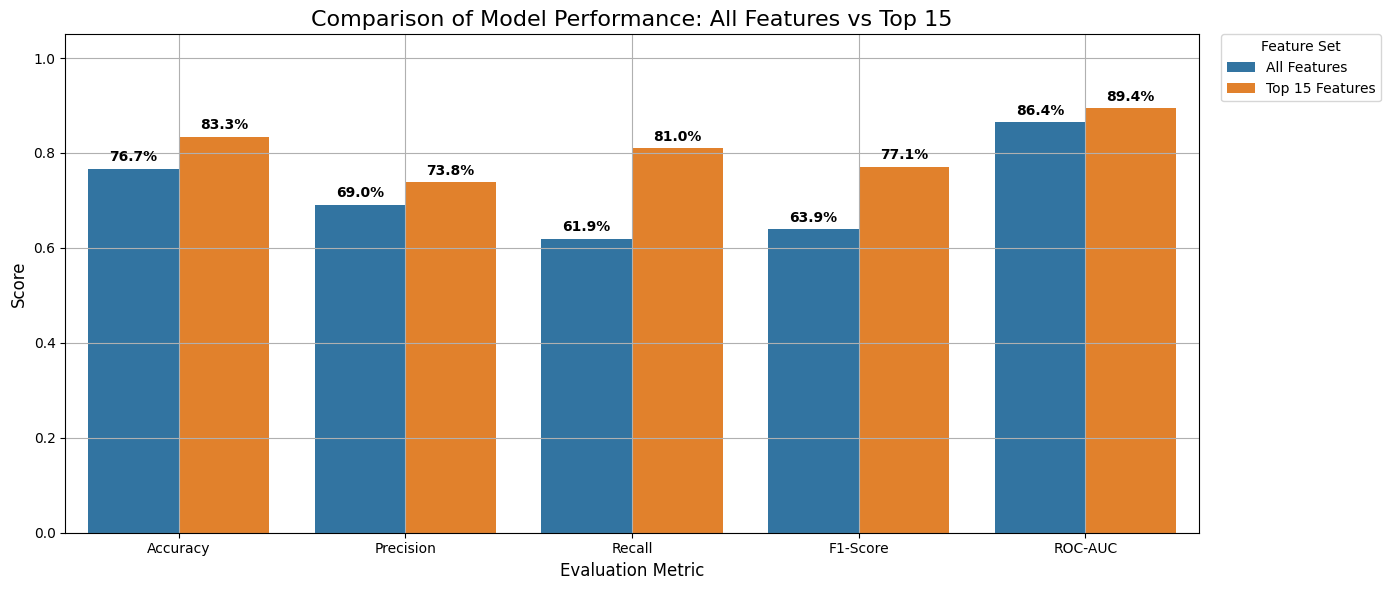

In [16]:
# Set visual style
import seaborn as sns
import matplotlib.pyplot as plt

# Melt the result dataframe for seaborn
melted = combined_results.melt(id_vars=["Model", "Feature Set"],
                               value_vars=["Accuracy", "Precision", "Recall", "F1-Score", "ROC-AUC"],
                               var_name="Metric",
                               value_name="Score")

plt.figure(figsize=(14, 6))
ax = sns.barplot(data=melted, x="Metric", y="Score", hue="Feature Set", ci=None)

# Add score labels on top of each bar, only if height > 0
for p in ax.patches:
    height = p.get_height()
    if height > 0:  # Only add text if bar has non-zero height
        ax.text(
            x=p.get_x() + p.get_width() / 2,
            y=height + 0.01,
            s=f'{height * 100:.1f}%',
            ha='center',
            va='bottom',
            fontsize=10,
            fontweight='bold'
        )

plt.title("Comparison of Model Performance: All Features vs Top 15", fontsize=16)
plt.xlabel("Evaluation Metric", fontsize=12)
plt.ylabel("Score", fontsize=12)

# Move legend outside
plt.legend(title="Feature Set", bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

plt.ylim(0, 1.05)
plt.grid(True)
plt.tight_layout()
plt.show()
